In [1]:
from visualize_correlations import *

/home/skhajehabdollahi/Documents/cppn-tensorflow-master/venv/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


# Load CPPN images

In [ ]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

## DON'T CHANGE ##
highlight_keys = [
    'total_neurons',
    'num_layers',
    'omega',
    'alpha',
    'mu'
]


corrs_means, corrs_quantiles, corr_vars, means_params = \
    architecture_correlation_means(dir, img_folder, highlight_keys,
                                   method, forceCalculate=False)
data_cppn = {
    'corrs_means': corrs_means,
    'corr_vars': corr_vars,
}

# Load global CPPN stats (small file)

In [ ]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

global_cppn_stats(dir, img_folder, method, forceCalculate=False)

# Load aesthetic images

In [ ]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

with open('save/img_architectures/big/aesthetic_tag.txt', 'r') as f:
    aesthetic_dirs = f.read().splitlines()
takeMean = False

aesthetic_corrs, aesthetic_corrs_vars, aesthetic_params = \
    aesthetic_correlations(dir, img_folder, method, takeMean=takeMean, forceCalculate=False)

data_aesthetic = {
    'corrs': aesthetic_corrs,
    'var': aesthetic_corrs_vars,
    'params': aesthetic_params
}

# Load natural images

In [ ]:
dir = 'natural_imgs/'
img_folders = ['Foliage', 'LandWater', 'Snow', 'Animals', 'Flowers', 'ManMade']
# img_folders = ['Animals', 'Flowers', 'ManMade']
method = 'fft_norm'  # 'fft_norm', 'sample'


corrs_means, _, corr_vars = \
    correlation_means(dir, img_folders, method, forceCalculate=False)

data_nat = {
    'corrs_means': corrs_means,
    'corr_var': corr_vars,
    'img_folders': img_folders
}

# (Fig 1) - CPPN Correlation functions 

In [2]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

## DON'T CHANGE ##
highlight_keys = [
    'total_neurons',
    'num_layers',
    'omega',
    'alpha',
    'mu'
]


corrs_means, corrs_quantiles, corr_vars, means_params = \
    architecture_correlation_means(dir, img_folder, highlight_keys,
                                   method, forceCalculate=False)
data_cppn = {
    'corrs_means': corrs_means,
    'corr_vars': corr_vars,
}

Loading correlation means: save/img_architectures/big/corrs/fft_norm/means/big_corr_means.txt


## Filter settings

In [3]:
## FILTERS 
N = [None]  # total_neurons
L = [None]  # num layers
omega = [None]  # omega
alpha = [None]  # alpha
mu = [None]  # mu

filters = {
    'total_neurons': N,
    'num_layers': L,
    'omega': omega,
    'alpha': alpha,
    'mu': mu,
}

if filters is not None:
    filtered_index = filter_corrs(means_params, filters)

    corrs_means = [corrs_means[i] for i in filtered_index]
    corrs_quantiles = [corrs_quantiles[i] for i in filtered_index]
    corr_vars = [corr_vars[i] for i in filtered_index]
    means_params = [means_params[i] for i in filtered_index]
##

latex_dict = {
        'total_neurons': 'N',
        'num_layers': 'L',
        'omega': '\\omega',
        'alpha': '\\alpha',
        'mu': '\\mu',
}

### Bin data, extract inset data

In [4]:
distances = dist_vec((1023, 1023))  ## assumes a 512x512 image.

#######################################################
# playing around with how the variances are calculated. comment this for new calculations!!
# corrs_vars = [corrs_vars[i] * corrs_means[i]
#               for i in range(len(corrs_vars))]
#######################################################

corr_means, bin_edges, _ = scipy.stats.binned_statistic(
    distances, corrs_means, statistic='mean', bins=300)

# corr_q25, _, _ = scipy.stats.binned_statistic(
#     distances, corrs_q25, statistic='mean', bins=300)

# corr_q75, _, _ = scipy.stats.binned_statistic(
#     distances, corrs_q75, statistic='mean', bins=300)

corr_var, _, _ = scipy.stats.binned_statistic(
    distances, corr_vars, statistic='mean', bins=300)

d = (bin_edges[:-1] + bin_edges[1:]) / 2


## DATA FOR INSET
highlight_main = 'num_layers'
highlight_inset = 'total_neurons'
filter_inset = 'num_layers'
L = 3  # inset value

arch_index = [i for i in range(len(means_params)) 
              if means_params[i][filter_inset] == L]
arch_means_params = [means_params[i] for i in arch_index]
arch_corr_means = [corr_means[i] for i in arch_index]
##

## Generate figure

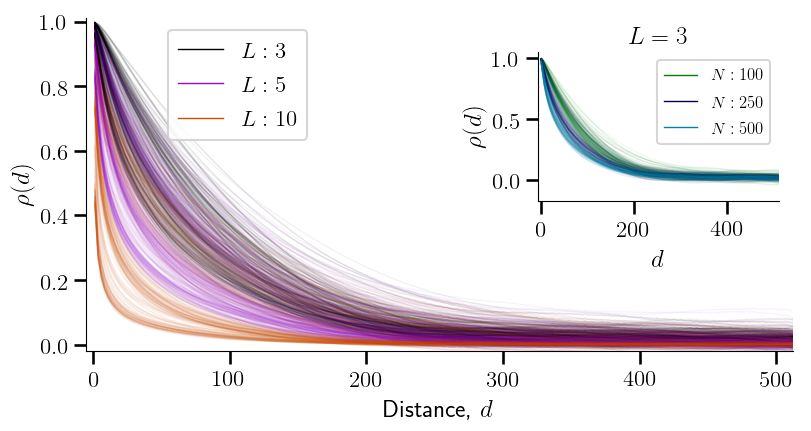

In [10]:
plt.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_context('talk')
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(8, 4.2), dpi=100, constrained_layout=True)
# fig.suptitle('Correlation functions of architecture parametrized CPPN generated images')
# plt.xlabel('Distance, $d$')

values = list(np.sort(np.unique([v[highlight_main] for v in means_params])))
norm = colors.Normalize(vmin=0, vmax=len(values))  # age/color mapping
cmap = plt.get_cmap('gnuplot')
ax.set_ylabel(r'$\rho(d)$')
ax.set_xlabel('Distance, $d$')

alpha = np.tanh(0.05 + 1 / len(corrs_means))  ## transparency related to number of lines

for i, corr in enumerate(corr_means):

    corr_value = means_params[i][highlight_main]

    c = cmap(norm(values.index(corr_value)))

    label = '$' + latex_dict[highlight_main] + ': ' + str(corr_value) + '$'

    ax.plot(d, corr, alpha=alpha, linewidth=1, c=c, label=label)

handles, labels = unique_labels(ax)

leg1 = ax.legend(handles, labels, bbox_to_anchor=(0.1, 1), loc='upper left')   # draw the legend with the filtered handles and labels lists
for h in leg1.legendHandles:
    h.set_alpha(1)
    
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


# ax.set_axisbelow(True)
# ax.minorticks_on()
# ax.grid(which='major', linestyle='-', color='black', alpha=0.1)
# ax.grid(which='minor', linestyle=':', color='black', alpha=0.1)


# a.set_xscale('log')
ax.set_xlim([-5, 512])
ax.set_ylim([-0.02, 1.01])

## INSET    

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0, 0, 1, 1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.64, 0.45, 0.34, 0.45])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
# mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

values = list(np.sort(np.unique([v[highlight_inset] for v in arch_means_params])))

norm = colors.Normalize(vmin=0, vmax=len(values))  # age/color mapping

ax2.set_title(f'$L={L}$')
ax2.set_ylabel(r'$\rho(d)$')
ax2.set_xlabel('$d$')
cmap = plt.get_cmap('ocean')


for i, corr in enumerate(arch_corr_means):

    corr_value = arch_means_params[i][highlight_inset]
    
    c = cmap(norm(values.index(corr_value)))

    label = '$' + latex_dict[highlight_inset] + ': ' + str(corr_value) + '$'

    if method == 'sample':
        ax2.plot(np.arange(0, len(corr)),
                   corr, alpha=alpha, linewidth=1, c=c, label=label)

    elif method == 'fft' or method == 'fft_windowed' or method == 'fft_norm':
        ax2.plot(d, corr, alpha=alpha, linewidth=1, c=c, label=label)

    else:
        raise Exception(r'Method must be either "fft", "fft_windowed" or "sample".')

handles, labels = unique_labels(ax2)

leg1 = ax2.legend(handles, labels, prop={'size': 12})  # draw the legend with the filtered handles and labels lists

for h in leg1.legendHandles:
    h.set_alpha(1)

# ax2.set_axisbelow(True)
# ax2.minorticks_on()
# ax2.grid(which='major', linestyle='-', color='black', alpha=0.1)
# ax2.grid(which='minor', linestyle=':', color='black', alpha=0.1)

# ax2.set_yscale('log')
# ax2.set_ylim(1e-7, 0.1)

# ax2.set_xscale('log')
ax2.set_xlim([-5, 512])
# ax2.add_patch(plt.Rectangle((-4, -0.17), 515, 1.2, lw=0.5, ec="k", fc="None"))

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')

time =  datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
name = 'fig1_' + time
filename = 'paper_figures/' + name + '.png'
filename_pdf = 'paper_figures/pdf/' + name + '.pdf'
plt.savefig(filename, density=600)
plt.savefig(filename_pdf, density=600)

plt.show()

# (Fig legacy 1) - Correlation difference and p-values (Global)

### Load data

In [4]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'
corrs_paths, _ = load_img_paths_and_params(dir, img_folder, method)

c_mean_t, c_var_t = global_cppn_stats(dir, img_folder, method, forceCalculate=False)

takeMean = False
aesthetic_corrs, aesthetic_corrs_vars, aesthetic_params = \
    aesthetic_correlations(dir, img_folder, method, takeMean=takeMean, forceCalculate=False)

data_aesthetic = {
    'corrs': aesthetic_corrs,
    'var': aesthetic_corrs_vars,
    'params': aesthetic_params
}

aes_stack_t = np.stack(data_aesthetic['corrs'])

Loading correlation means: save/img_architectures/big/corrs/fft_norm/stats/big_corr_stats.txt
Loading aesthetic correlation: save/img_architectures/big/corrs/fft_norm/aesthetic/big_corr_aesthetics.txt


### Binning, calculate differences and p-values

In [6]:
distances = dist_vec((1023, 1023))
c_mean, bin_edges, _ = scipy.stats.binned_statistic(
            distances, c_mean_t, statistic='mean', bins=512)

c_var, _, _ = scipy.stats.binned_statistic(
            distances, c_var_t, statistic='mean', bins=512)

aes_stack, _, _ = scipy.stats.binned_statistic(
            distances, aes_stack_t, statistic='mean', bins=512)

distances = (bin_edges[1:] + bin_edges[0:-1]) / 2

aes_mean = np.mean(aes_stack, axis=0)
N1 = np.shape(aes_stack)[0]
aes_sigma = np.std(aes_stack, axis=0)

cppn_mean = c_mean
N2 = len(corrs_paths)
cppn_sigma = np.sqrt(c_var)

diff = aes_mean - cppn_mean
vars = (aes_sigma ** 2 / N1) + (c_var / N2)
t = diff / (np.sqrt(vars))

dof1 = N1 - 1
dof2 = N2 - 1
dof = (vars) ** 2 / ((aes_sigma ** 4 / (N1 ** 2 * dof1)) + (c_var ** 2 / (N2 ** 2 * dof2)))

pval = scipy.stats.t.sf(np.abs(t), dof) * 2

### Plot

(-5, 512)

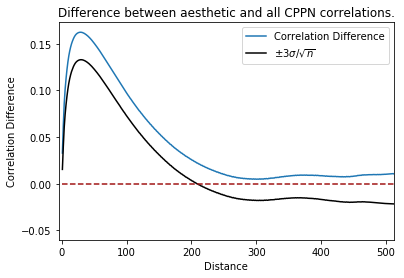

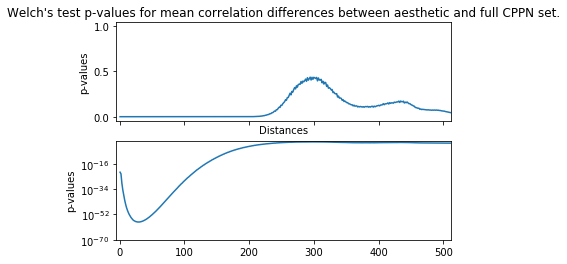

In [7]:
fig, ax = plt.subplots()

sigma_dev = 3
dev = sigma_dev * cppn_sigma / np.sqrt(N1)
ax.plot(distances, diff, label='Correlation Difference')
ax.plot(distances, diff - dev, c='k',
           label=f'$\pm{sigma_dev}\sigma/\sqrt{{n}}$')

x1, y1 = [min(distances), max(distances)], [0, 0]
c = np.divide([160, 19, 19], 255)
ax.plot(x1, y1, '--', c=c)

ax.set_xlabel('Distance')
ax.set_ylabel('Correlation Difference')
ax.set_title('Difference between aesthetic and all CPPN correlations.')
ax.set_xlim([-5, 512])

ax.legend()

# PLOT P-VALUES

fig, ax = plt.subplots(2, 1, sharex=True)
ax2.plot(distances, pval)
ax[1].plot(distances, pval)

ax2.set_title('Welch\'s test p-values for mean correlation differences between aesthetic and full CPPN set.')
ax[0].set_xlabel('Distances')
ax[0].set_ylabel('p-values')
ax[1].set_ylabel('p-values')

ax[1].set_yscale('log')
ax[1].set_ylim([1e-70, 2])

ax[0].set_xlim([-5, 512])
ax[1].set_xlim([-5, 512])

# (Fig - legacy 2) - Correlation difference and P-values (Local)
## (N, L) = (100, 3)

### Load aesthetic images and CPPN images from the same architecture. Remove aesthetic images from CPPN set. 

In [8]:
N = 100
L = 3

dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'
img_dir = os.path.join(dir, img_folder)

corrs_folder = os.path.join(img_dir, 'corrs', method)
cppn_arch_paths = glob.glob(os.path.join(corrs_folder, f'N{N}*L{L}*.txt'))

jsons_folder = os.path.join(img_dir, 'json')
cppn_arch_json_paths = glob.glob(os.path.join(jsons_folder, f'N{N}*L{L}*.json'))

imgs_params = []
for path in cppn_arch_json_paths:

    imgs_params.append(sampler.loadJSON(path))
	
aes_in_cppn_index = [j for i in range(len(aesthetic_params)) for j in range(len(imgs_params))
                     if aesthetic_params[i] == imgs_params[j]]

mask = np.ones(len(cppn_arch_paths), dtype=bool)
mask[aes_in_cppn_index] = 0

## REDO ABOVE CALCULATIONS NOW WITH MASK ##

aes_index = [i for i in range(len(aesthetic_params)) if (aesthetic_params[i]['num_layers'] == L and aesthetic_params[i]['total_neurons'] == N)]

dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'
img_dir = os.path.join(dir, img_folder)

corrs_folder = os.path.join(img_dir, 'corrs', method)

cppn_arch_paths = glob.glob(os.path.join(corrs_folder, f'N{N}*L{L}*.txt'))

cppn_arch_paths = [cppn_arch_paths[i] for i in range(len(cppn_arch_paths)) if mask[i] == True]

# LOAD IMAGES #

corrs = []
for corr_path in cppn_arch_paths:
    with open(corr_path, 'rb') as fp:
        corrs.append(pickle.load(fp))
        
aes_stack_t = np.stack([data_aesthetic['corrs'][i] for i in aes_index])

### Binning, calculate difference and p-values

In [12]:
distances = dist_vec((1023, 1023))
corrs_binned, bin_edges, _ = scipy.stats.binned_statistic(
            distances, corrs, statistic='mean', bins=512)

aes_stack, _, _ = scipy.stats.binned_statistic(
            distances, aes_stack_t, statistic='mean', bins=512)
			
distances = (bin_edges[1:] + bin_edges[0:-1]) / 2

aes_mean = np.mean(aes_stack, axis=0)
N1 = np.shape(aes_stack)[0]
aes_sigma = np.std(aes_stack, axis=0)

cppn_mean = np.mean(corrs_binned, axis=0)
N2 = len(corrs_binned)
cppn_sigma = np.std(corrs_binned, axis=0)

diff = aes_mean - cppn_mean
vars = (aes_sigma ** 2 / N1) + (cppn_sigma ** 2 / N2)
t = diff / (np.sqrt(vars))

dof1 = N1 - 1
dof2 = N2 - 1
dof = (vars) ** 2 / ((aes_sigma ** 4 / (N1 ** 2 * dof1)) + (cppn_sigma ** 4 / (N2 ** 2 * dof2)))

pval = scipy.stats.t.sf(np.abs(t), dof) * 2

### Plot

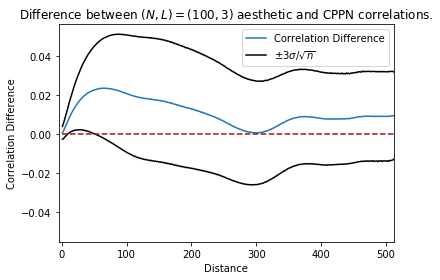

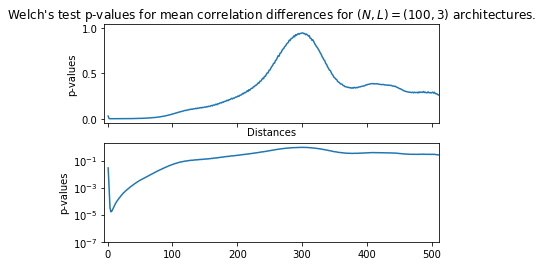

In [13]:
# PLOT DIFFERENCES
fig, ax = plt.subplots()

sigma_dev = 3
dev = sigma_dev * cppn_sigma / np.sqrt(N1)
ax.plot(distances, diff, label='Correlation Difference')
ax.plot(distances, diff - dev, c='k',
           label=f'$\pm{sigma_dev}\sigma/\sqrt{{n}}$')

ax.plot(distances, diff + dev, c='k')
x1, y1 = [0, max(distances)], [0, 0]
c = np.divide([160, 19, 19], 255)
ax.plot(x1, y1, '--', c=c)

ax.set_xlabel('Distance')
ax.set_ylabel('Correlation Difference')
ax.set_title(f'Difference between $(N,L) = ({N},{L})$ aesthetic and CPPN correlations.')
ax.set_xlim([-5, 512])
ax.legend()


# PLOT P-VALUES

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(distances, pval)
ax[1].plot(distances, pval)

ax[0].set_title(f'Welch\'s test p-values for mean correlation differences for $(N,L) = ({N},{L})$ architectures.')
ax[0].set_xlabel('Distances')
ax[0].set_ylabel('p-values')
ax[1].set_ylabel('p-values')

ax[1].set_yscale('log')
ax[1].set_ylim([1e-7, 2])

for a in ax.flatten():
    a.set_xlim([-5, 512])

# (Fig 2) - P-values with inset of correlation functions
## All aesthetic and all CPPN
#### Main: CPPN correlation functions (hairlines); Inset: p-test for correlation difference between aesthetic and CPPN 

### Load data

In [2]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'
corrs_paths, _ = load_img_paths_and_params(dir, img_folder, method)

# load global stats
c_mean_t, c_var_t = global_cppn_stats(dir, img_folder, method, forceCalculate=False)

# load all cppn means

highlight_keys = [
    'total_neurons',
    'num_layers',
    'omega',
    'alpha',
    'mu'
]
    
corrs_means, corrs_quantiles, corr_vars, means_params = \
    architecture_correlation_means(dir, img_folder, highlight_keys,
                                   method, forceCalculate=False)
data_cppn = {
    'corrs_means': corrs_means,
    'corr_vars': corr_vars,
}

# load aesthetic 
takeMean = False
aesthetic_corrs, aesthetic_corrs_vars, aesthetic_params = \
    aesthetic_correlations(dir, img_folder, method, takeMean=takeMean, forceCalculate=False)

data_aesthetic = {
    'corrs': aesthetic_corrs,
    'var': aesthetic_corrs_vars,
    'params': aesthetic_params
}

aes_stack_t = np.stack(data_aesthetic['corrs'])

Loading correlation means: save/img_architectures/big/corrs/fft_norm/stats/big_corr_stats.txt
Loading correlation means: save/img_architectures/big/corrs/fft_norm/means/big_corr_means.txt
Loading aesthetic correlation: save/img_architectures/big/corrs/fft_norm/aesthetic/big_corr_aesthetics.txt


### Binning, calculate differences and p-values

In [3]:
distances = dist_vec((1023, 1023))
c_mean, bin_edges, _ = scipy.stats.binned_statistic(
            distances, c_mean_t, statistic='mean', bins=512)

c_var, _, _ = scipy.stats.binned_statistic(
            distances, c_var_t, statistic='mean', bins=512)

aes_stack, _, _ = scipy.stats.binned_statistic(
            distances, aes_stack_t, statistic='mean', bins=512)

corr_means, bin_edges, _ = scipy.stats.binned_statistic(
            distances, corrs_means, statistic='mean', bins=512)

d = (bin_edges[1:] + bin_edges[0:-1]) / 2

aes_mean = np.mean(aes_stack, axis=0)
N1 = np.shape(aes_stack)[0]
aes_sigma = np.std(aes_stack, axis=0)

cppn_mean = c_mean
N2 = len(corrs_paths)
cppn_sigma = np.sqrt(c_var)

diff = aes_mean - cppn_mean
vars = (aes_sigma ** 2 / N1) + (c_var / N2)
t = diff / (np.sqrt(vars))

dof1 = N1 - 1
dof2 = N2 - 1
dof = (vars) ** 2 / ((aes_sigma ** 4 / (N1 ** 2 * dof1)) + (c_var ** 2 / (N2 ** 2 * dof2)))

pval = scipy.stats.t.sf(np.abs(t), dof) * 2

### Plot - Main: mean CPPN, mean aesthetic, CPPN hairs - Inset: p-values for mean differences

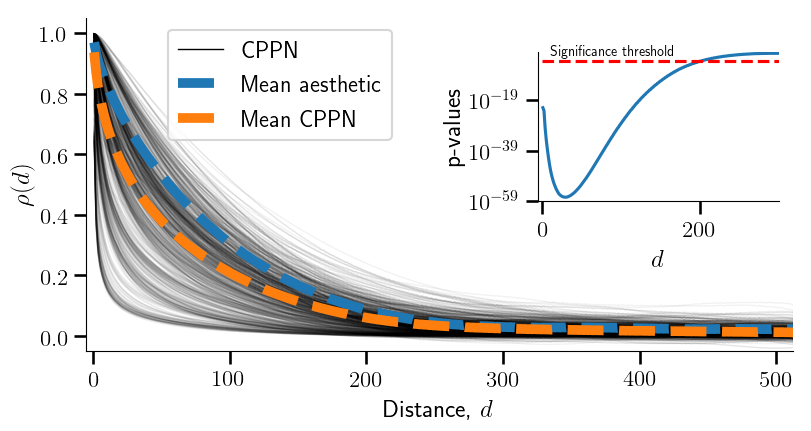

In [15]:
plt.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_context('talk')
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(8, 4.2), dpi=100, constrained_layout=True)
# fig.suptitle('Correlation functions of CPPN generated images and Aesthetic images')


ax.set_ylabel(r'$\rho(d)$')
ax.set_xlabel('Distance, $d$')
c = 'k'

alpha = np.tanh(0.05 + 1 / len(corrs_means))  ## transparency related to number of lines

for i, corr in enumerate(corr_means):
    ax.plot(d, corr, alpha=alpha, linewidth=1, c=c, label='CPPN')
        
ax.plot(d, np.mean(aes_stack, axis=0), '--', lw=7, label='Mean aesthetic')
ax.plot(d, np.mean(corr_means, axis=0), '--', lw=7, label='Mean CPPN')

handles, labels = unique_labels(ax)

leg1 = ax.legend(handles, labels, bbox_to_anchor=(0.1, 1), loc='upper left')  # draw the legend with the filtered handles and labels lists
for h in leg1.legendHandles:
    h.set_alpha(1)


# ax.set_axisbelow(True)
# ax.minorticks_on()
# ax.grid(which='major', linestyle='-', color='black', alpha=0.1)
# ax.grid(which='minor', linestyle=':', color='black', alpha=0.1)


# a.set_xscale('log')
ax.set_xlim([-5, 512])
ax.set_ylim([-0.05, 1.05])


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## INSET    

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0, 0, 1, 1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.64, 0.45, 0.34, 0.45])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
# mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

# PLOT P-VALUES

ax2.plot(d, pval)

# ax2.set_title(f'Welch\'s test')
ax2.set_xlabel('$d$')
ax2.set_ylabel('p-values')

ax2.set_yscale('log')
ax2.set_ylim([1e-59, 2])


ax2.set_xlim([-5, 300])
  

boncor = np.sum(d < 300)
onesidecor = 2
thresh = onesidecor * 0.05 / boncor

x1, y1 = [0, max(d)], [thresh, thresh]
ax2.plot(x1, y1, '--', c='r')
ax2.annotate('Significance threshold', [10, 100*thresh])

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')

time =  datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
name = 'fig2' + time
filename = 'paper_figures/' + name + '.png'
filename_pdf = 'paper_figures/pdf/' + name + '.pdf'
plt.savefig(filename, density=600)
plt.savefig(filename_pdf, density=600)

plt.show()

In [10]:
min_sig = np.min(d[pval < thresh])
max_sig = np.max(d[pval < thresh])
print(min_sig, max_sig)

0.7057257132545426 202.54327970405373


# (Fig 3) - P-values with inset of correlation functions (local)
## (N, L) = (3, 100)
#### Main: CPPN correlation functions (hairlines); Inset: p-test for correlation difference between aesthetic and CPPN 

### Load aesthetic

In [2]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

takeMean = False
aesthetic_corrs, aesthetic_corrs_vars, aesthetic_params = \
    aesthetic_correlations(dir, img_folder, method, takeMean=takeMean, forceCalculate=False)

data_aesthetic = {
    'corrs': aesthetic_corrs,
    'var': aesthetic_corrs_vars,
    'params': aesthetic_params
}

Loading aesthetic correlation: save/img_architectures/big/corrs/fft_norm/aesthetic/big_corr_aesthetics.txt


### Load and mask CPPN correlations

In [3]:
N = 100
L = 3

dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'
img_dir = os.path.join(dir, img_folder)

corrs_folder = os.path.join(img_dir, 'corrs', method)
cppn_arch_paths = glob.glob(os.path.join(corrs_folder, f'N{N}*L{L}*.txt'))

jsons_folder = os.path.join(img_dir, 'json')
cppn_arch_json_paths = glob.glob(os.path.join(jsons_folder, f'N{N}*L{L}*.json'))

imgs_params = []
for path in cppn_arch_json_paths:

    imgs_params.append(sampler.loadJSON(path))
	
aes_in_cppn_index = [j for i in range(len(aesthetic_params)) for j in range(len(imgs_params))
                     if aesthetic_params[i] == imgs_params[j]]

mask = np.ones(len(cppn_arch_paths), dtype=bool)
mask[aes_in_cppn_index] = 0

## REDO ABOVE CALCULATIONS NOW WITH MASK ##

aes_index = [i for i in range(len(aesthetic_params)) if (aesthetic_params[i]['num_layers'] == L and aesthetic_params[i]['total_neurons'] == N)]

dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'
img_dir = os.path.join(dir, img_folder)

corrs_folder = os.path.join(img_dir, 'corrs', method)

cppn_arch_paths = glob.glob(os.path.join(corrs_folder, f'N{N}*L{L}*.txt'))

cppn_arch_paths = [cppn_arch_paths[i] for i in range(len(cppn_arch_paths)) if mask[i] == True]

# LOAD IMAGES #

corrs = []
for corr_path in cppn_arch_paths:
    with open(corr_path, 'rb') as fp:
        corrs.append(pickle.load(fp))
        
aes_stack_t = np.stack([data_aesthetic['corrs'][i] for i in aes_index])

### Bin, calculate p-values

In [4]:
distances = dist_vec((1023, 1023))
corrs_binned, bin_edges, _ = scipy.stats.binned_statistic(
            distances, corrs, statistic='mean', bins=512)

aes_stack, _, _ = scipy.stats.binned_statistic(
            distances, aes_stack_t, statistic='mean', bins=512)

d = (bin_edges[1:] + bin_edges[0:-1]) / 2

aes_mean = np.mean(aes_stack, axis=0)
N1 = np.shape(aes_stack)[0]
aes_sigma = np.std(aes_stack, axis=0)

cppn_mean = np.mean(corrs_binned, axis=0)
N2 = len(corrs_binned)
cppn_sigma = np.std(corrs_binned, axis=0)

diff = aes_mean - cppn_mean
vars = (aes_sigma ** 2 / N1) + (cppn_sigma ** 2 / N2)
t = diff / (np.sqrt(vars))

dof1 = N1 - 1
dof2 = N2 - 1
dof = (vars) ** 2 / ((aes_sigma ** 4 / (N1 ** 2 * dof1)) + (cppn_sigma ** 4 / (N2 ** 2 * dof2)))

pval = scipy.stats.t.sf(np.abs(t), dof) * 2

### Plot

2.1171771397636276 37.40346280249076


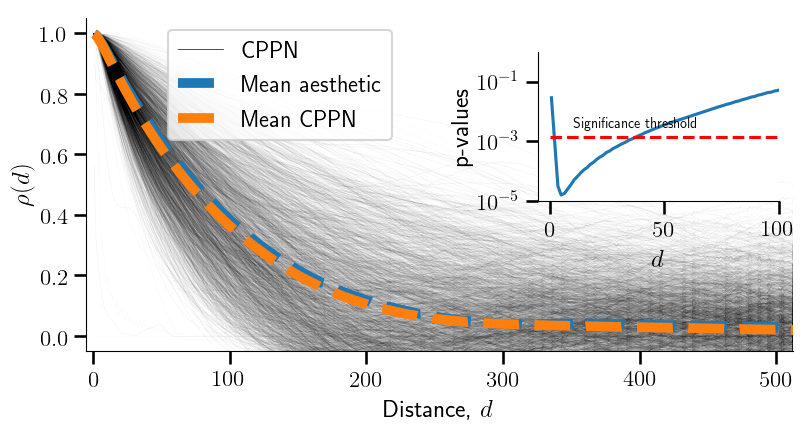

In [5]:
plt.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_context('talk')
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(8, 4.2), dpi=100, constrained_layout=True)
# fig.suptitle(f'Correlation functions of (N, L) = ({N}, {L}) CPPN and Aesthetic images')


ax.set_ylabel(r'$\rho(d)$')
ax.set_xlabel('Distance, $d$')

alpha = np.tanh(0.05 + 1 / len(corrs_binned))  ## transparency related to number of lines



for i, corr in enumerate(corrs_binned):
    ax.plot(d, corr, alpha=alpha/2, lw=0.5, c='k', label='CPPN')
    
ax.plot(d, np.mean(aes_stack, axis=0), '--', lw=7, label='Mean aesthetic')
ax.plot(d, np.mean(corrs_binned, axis=0), '--', lw=7, label='Mean CPPN')
    
# for i, corr in enumerate(aes_stack):
#     ax.plot(d, corr, alpha=alpha, ls=':', lw=2, c='r', label='Aesthetic')

# main axis legend
handles, labels = unique_labels(ax)

leg1 = ax.legend(handles, labels, bbox_to_anchor=(0.1, 1), loc='upper left')  # draw the legend with the filtered handles and labels lists
for h in leg1.legendHandles:
    h.set_alpha(1)


# ax.set_axisbelow(True)
# ax.minorticks_on()
# ax.grid(which='major', linestyle='-', color='black', alpha=0.1)
# ax.grid(which='minor', linestyle=':', color='black', alpha=0.1)


# a.set_xscale('log')
ax.set_xlim([-5, 512])
ax.set_ylim([-0.05, 1.05])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## INSET    

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0, 0, 1, 1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.64, 0.45, 0.34, 0.45])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
# mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

# PLOT P-VALUES

ax2.plot(d, pval)

# ax2.set_title(f'Welch\'s test')
ax2.set_xlabel('$d$')
ax2.set_ylabel('p-values')

ax2.set_yscale('log')
ax2.set_ylim([1e-5, 1])
ax2.set_xlim([-5, 100])

boncor = np.sum(d < 100)
onesidecor = 2
thresh = onesidecor * 0.05 / boncor

x1, y1 = [0, max(d)], [thresh, thresh]
ax2.plot(x1, y1, '--', c='r')
ax2.annotate('Significance threshold', [10, 2*thresh])

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')

time =  datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
name = f'fig3_app_N_{N}_L_{L}_' + time
filename = 'paper_figures/' + name + '.png'
filename_pdf = 'paper_figures/pdf/' + name + '.pdf'
plt.savefig(filename, density=600)
plt.savefig(filename_pdf, density=600)

min_sig = np.min(d[pval < thresh])
max_sig = np.max(d[pval < thresh])
print(min_sig, max_sig)

# ax2.fill_betweenx([10-6, 0], 0, , alpha=0.2, color='r')

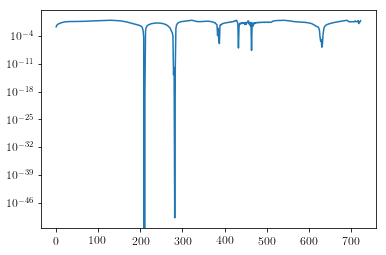

# (Fig 4) - Architecture aesthetic scatter plot

## Load aesthetic params

In [2]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

with open('save/img_architectures/big/aesthetic_tag.txt', 'r') as f:
    aesthetic_dirs = f.read().splitlines()
takeMean = False

_, _, aesthetic_params = \
    aesthetic_correlations(dir, img_folder, method, takeMean=takeMean, forceCalculate=False)

Loading aesthetic correlation: save/img_architectures/big/corrs/fft_norm/aesthetic/big_corr_aesthetics.txt


### Plot

NameError: name 'xzero' is not defined

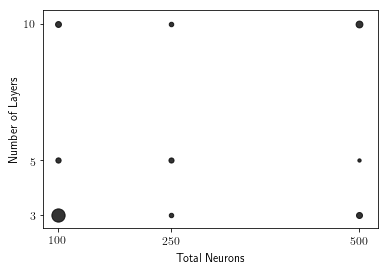

In [31]:
## ARCHITECTURE SCATTER PLOT ## 

import itertools
Ls=[3, 5, 10]
Ns=[100, 250, 500]

x = list(itertools.product(Ns, Ls))
	
# x = list(set([(p['total_neurons'], p['num_layers']) for p in means_params]))  # need to load all of cppn data for this

aes_counter = np.zeros(len(x))

for p in aesthetic_params:
    ii = x.index((p['total_neurons'], p['num_layers']))
    aes_counter[ii] += 1
    
fig, ax = plt.subplots()

for i, ss in enumerate(aes_counter):
    s = ss/2 + 10
    xx, yy = x[i]
    ax.scatter(xx, yy, s=s, alpha=0.8, c='k')
    
ax.set_xlabel('Total Neurons')
ax.set_ylabel('Number of Layers')
# xzero = np.min(Ns) - max(aes_counter)/4
# yzero = 2
# ax.set_xlim([xzero, np.max(Ns) + np.abs(xzero)])
# ax.set_ylim([yzero, np.max(Ls) + np.abs(yzero)])

yt = list(set([f[1] for f in x]))
xt = list(set([f[0] for f in x]))
ax.set_xticks(xt)
ax.set_yticks(yt)
ax.set_aspect((np.max(Ns) - xzero)/(np.max(Ls) - yzero))

time =  datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
name = 'fig4_' + time
filename = 'paper_figures/' + name + '.png'
filename_pdf = 'paper_figures/pdf/' + name + '.pdf'
plt.savefig(filename, density=600)
plt.savefig(filename_pdf, density=600)

# (Fig 5) Natural images correlation functions

### Load (N, L) = (3,100) aesthetic corrs

In [3]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

takeMean = False
aesthetic_corrs, aesthetic_corrs_vars, aesthetic_params = \
    aesthetic_correlations(dir, img_folder, method, takeMean=takeMean, forceCalculate=False)

data_aesthetic = {
    'corrs': aesthetic_corrs,
    'var': aesthetic_corrs_vars,
    'params': aesthetic_params
}

# N = 100
# L = 3

# aes_index = [i for i in range(len(aesthetic_params)) if (aesthetic_params[i]['num_layers'] == L and aesthetic_params[i]['total_neurons'] == N)]
# aes_stack_t = np.stack([data_aesthetic['corrs'][i] for i in aes_index])

Ns = [100, 250 , 500]
Ls = [3, 5, 10]

aes_stack_t = []
NL = []
for N in Ns:
    for L in Ls:
        NL.append((N, L))
        aes_index = [i for i in range(len(aesthetic_params)) if (aesthetic_params[i]['num_layers'] == L and aesthetic_params[i]['total_neurons'] == N)]
        aes_stack_t.append(np.stack([data_aesthetic['corrs'][i] for i in aes_index]))
        
        

Loading aesthetic correlation: save/img_architectures/big/corrs/fft_norm/aesthetic/big_corr_aesthetics.txt


### Load natural corrs

In [4]:
dir = 'natural_imgs/'
img_folders = ['Foliage', 'LandWater', 'Animals', 'Flowers', 'ManMade']
# img_folders = ['Animals', 'Flowers', 'ManMade']
method = 'fft_norm'  # 'fft_norm', 'sample'


corrs_means, _, corr_vars = \
    correlation_means(dir, img_folders, method, forceCalculate=False)

data_nat = {
    'corrs_means': corrs_means,
    'corr_var': corr_vars,
    'img_folders': img_folders
}

Loading correlation means: natural_imgs/Foliage/corrs/fft_norm/means/Foliage_corr_means.txt
Loading correlation means: natural_imgs/LandWater/corrs/fft_norm/means/LandWater_corr_means.txt
Loading correlation means: natural_imgs/Animals/corrs/fft_norm/means/Animals_corr_means.txt
Loading correlation means: natural_imgs/Flowers/corrs/fft_norm/means/Flowers_corr_means.txt
Loading correlation means: natural_imgs/ManMade/corrs/fft_norm/means/ManMade_corr_means.txt


### Load CPPN corrs

In [5]:
dir = 'save/img_architectures'
img_folder = 'big'
method = 'fft_norm'

## DON'T CHANGE ##
highlight_keys = [
    'total_neurons',
    'num_layers',
    'omega',
    'alpha',
    'mu'
]


corrs_means, corrs_quantiles, corr_vars, means_params = \
    architecture_correlation_means(dir, img_folder, highlight_keys,
                                   method, forceCalculate=False)
data_cppn = {
    'corrs_means': corrs_means,
    'corr_vars': corr_vars,
}

Loading correlation means: save/img_architectures/big/corrs/fft_norm/means/big_corr_means.txt


### Bin

In [6]:
distances = dist_vec((1023, 1023))  ## assumes a 512x512 image.

# aes_stack, bin_edges, _ = scipy.stats.binned_statistic(
#     distances, aes_stack_t, statistic='mean', bins=512)

corr_cppn, _, _ = scipy.stats.binned_statistic(
    distances, data_cppn['corrs_means'], statistic='mean', bins=512)

corr_nat = []
for corr_n in data_nat['corrs_means']:
    corr_nat_t, _, _ = scipy.stats.binned_statistic(
        distances, corr_n[0], statistic='mean', bins=512)
    corr_nat.append(corr_nat_t)

aes_stack = []
for corr in aes_stack_t:
    aes_stack_t2, bin_edges, _ = scipy.stats.binned_statistic(
        distances, corr, statistic='mean', bins=512)
    
    aes_stack.append(aes_stack_t2)
    

d = (bin_edges[:-1] + bin_edges[1:]) / 2

### Plot

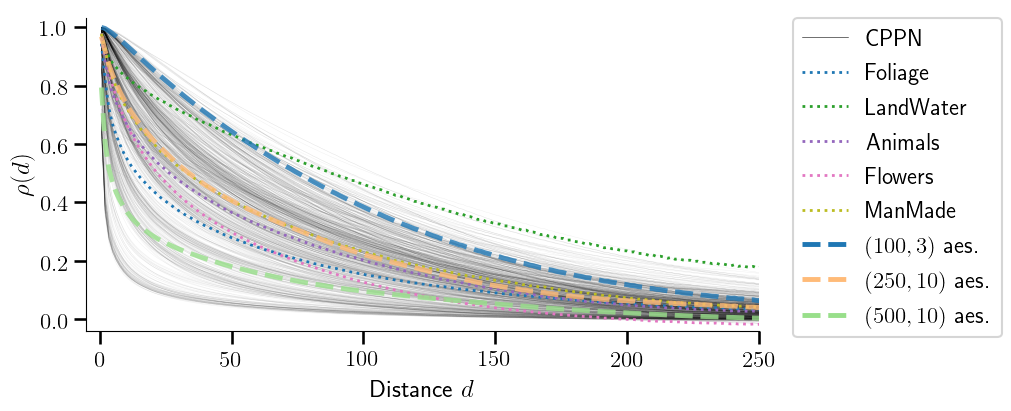

In [8]:
plt.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_context('talk')
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 10})


fig, ax = plt.subplots(figsize=(10, 4), dpi=100, constrained_layout=True)
# fig.suptitle('Correlation functions of architecture parametrized CPPN generated images')
plt.xlabel('Distance')

ax.set_ylabel(r'$\rho(d)$')
ax.set_xlabel('Distance $d$')

alpha = np.tanh(0.05 + 1 / len(corrs_means))  ## transparency related to number of lines

for corr in corr_cppn:
    ax.plot(d, corr, alpha=alpha, lw=0.4, c='k', label='CPPN')

cmap = plt.get_cmap('tab10')
norm = colors.Normalize(vmin=0, vmax=len(corr_nat))  # age/color mapping
for i, corr in enumerate(corr_nat):
    c = cmap(norm(i))
    ax.plot(d, corr, ':', alpha=1, lw=2, c=c, label=img_folders[i])
    
# cmap = plt.get_cmap('ocean')
# norm = colors.Normalize(vmin=0, vmax=0)  # age/color mapping
# c = cmap(norm(0))
# ax.plot(d, np.mean(aes_stack, axis=0), '--', c=c, alpha=1, lw=4,
#         label=f'$(N, L) = ({N},{L})$ aesthetic')

aes_plot_index = [0, 5, 8]
cmap = plt.get_cmap('tab20')
norm = colors.Normalize(vmin=0, vmax=30)  # age/color mapping


for i in aes_plot_index:
    c = cmap(norm(i))
    ax.plot(d, np.mean(aes_stack[i], axis=0), '--', c=c, alpha=0.8, lw=3.5,
        label=f'$({NL[i][0]},{NL[i][1]})$ aes.')

handles, labels = unique_labels(ax)

leg1 = ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)  # draw the legend with the filtered handles and labels lists

for h in leg1.legendHandles:
    h.set_alpha(1)


# ax.set_axisbelow(True)
# ax.minorticks_on()
# ax.grid(which='major', linestyle='-', color='black', alpha=0.1)
# ax.grid(which='minor', linestyle=':', color='black', alpha=0.1)


# ax.set_yscale('log')
# ax.set_ylim([0.01, 1])

ax.set_xlim([-5, 250])
ax.set_ylim([-0.04, 1.03])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

time =  datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
name = 'fig5_' + time
filename = 'paper_figures/' + name + '.png'
filename_pdf = 'paper_figures/pdf/' + name + '.pdf'
plt.savefig(filename, density=600)
plt.savefig(filename_pdf, density=600)

In [9]:
len(aes_stack[0])

333

In [22]:
NL

[(100, 3),
 (100, 5),
 (100, 10),
 (250, 3),
 (250, 5),
 (250, 10),
 (500, 3),
 (500, 5),
 (500, 10)]